# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'1.12.0'

## Import the Data

In [3]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
import gzip
import sys
import _pickle as cPickle
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [4]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [5]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [6]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [7]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [8]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [10]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [11]:
x_train.shape

(60000, 784)

In [12]:
x_test.shape

(10000, 784)

## Reshape the labels

In [13]:
y_train.shape

(60000,)

In [14]:
y_test.shape

(10000,)

In [15]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [16]:
num_classes = len(np.unique(y_train))
num_classes

10

In [17]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [18]:
y_train.shape

(60000, 10)

In [19]:
y_test.shape

(10000, 10)

In [20]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

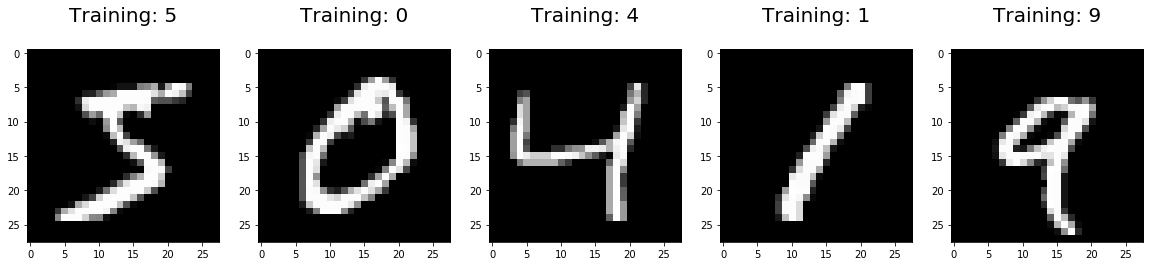

In [21]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [36]:
# learning rate
learning_rate = 0.5
# number of epoch to train our model
epochs = 10
# size of our mini batch
batch_size = 128

In [23]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return  

## Defined our model

In [51]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    #model.add(tf.keras.layers.Dense(512, 
    #                input_dim=dim_input, 
    #                kernel_initializer=tf.keras.initializers.he_normal(),
    #                bias_initializer=tf.keras.initializers.Zeros(),
    #                activation='relu'))
    # last layer
    #model.add(tf.keras.layers.Dense(num_classes, 
    #                kernel_initializer=tf.keras.initializers.he_normal(),
    #                bias_initializer=tf.keras.initializers.Zeros(),
    #                activation='softmax'))
    
    # hidden layer
    model.add(tf.keras.layers.Dense(512, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(512,  
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
        
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser
    optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp: keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [52]:
# build the model
model = baseline_model()

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [60]:
%%time
# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=20,
               batch_size=512, 
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 0.02215
Epoch 1/20
 accurary on the training set 0.9935
 accurary on the testing set 0.9768
 - 19s - loss: 0.0658 - acc: 0.9822 - val_loss: 0.1239 - val_acc: 0.9768
Reached epoch   1 cost J = 0.02167
Epoch 2/20
 accurary on the training set 0.9935
 accurary on the testing set 0.9764
 - 22s - loss: 0.0715 - acc: 0.9824 - val_loss: 0.1297 - val_acc: 0.9764
Reached epoch   2 cost J = 0.02285
Epoch 3/20
 accurary on the training set 0.9931
 accurary on the testing set 0.9760
 - 20s - loss: 0.0740 - acc: 0.9821 - val_loss: 0.1287 - val_acc: 0.9760
Reached epoch   3 cost J = 0.02532
Epoch 4/20
 accurary on the training set 0.9927
 accurary on the testing set 0.9770
 - 21s - loss: 0.0756 - acc: 0.9812 - val_loss: 0.1079 - val_acc: 0.9770
Reached epoch   4 cost J = 0.02384
Epoch 5/20
 accurary on the training set 0.9932
 accurary on the testing set 0.9762
 - 19s - loss: 0.0673 - acc: 0.9824 - val_loss: 0.1150 - val_ac

In [55]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12968987973493823
Test accuracy: 0.9705


In [56]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.06832173637855157
Train accuracy: 0.97995


## Plot for accuracy and loss

In [57]:
def plot_acc_loss(history):
    # plot the training loss and accuracy
    fig = plt.figure(figsize=(9, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.6 )
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(np.arange(0, EPOCHS), history.history['acc'], 'b', label='training accuracy')
    ax1.plot(np.arange(0, EPOCHS), history.history['val_acc'], 'r', label='validation accuracy');
    ax1.set_title('Accuracy')
    ax1.set_xlabel("Number of epoch ")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="best")


    ax2.plot(np.arange(0, EPOCHS), history.history["loss"], label="training loss")
    ax2.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="validation loss")
    ax2.set_title("Loss")
    ax2.set_xlabel("Number of epoch ")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="best");
    
    print('Loss:')
    print('  - loss [training dataset]: {0:.3f}'.format(history.history['loss'][-1]))
    print('  - loss [validation dataset: {0:.3f}'.format(history.history['val_loss'][-1]))
    print('')
    print('Accuracy:')
    print('  - accuracy [training dataset]: {:.2f}%'.format(100*history.history['acc'][-1]))
    print('  - accuracy [validation dataset: {:.2f}%'.format(100*history.history['val_acc'][-1]))

Loss:
  - loss [training dataset]: 0.054
  - loss [validation dataset: 0.148

Accuracy:
  - accuracy [training dataset]: 98.62%
  - accuracy [validation dataset: 97.41%


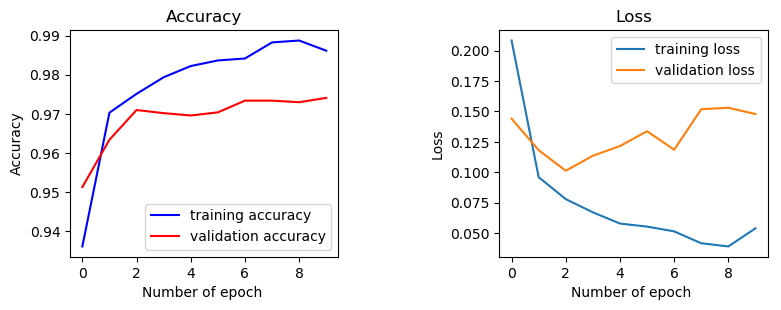

In [46]:
EPOCHS=epochs
plot_acc_loss(hist)

In [58]:
# with keras optimiser we can save the model+weight
model.save('keras_model.h5')